In [0]:
!kill -9 -1

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1jQHuKASvmDZSZfzUwVBeGyLwhHTe7-W1'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

In [4]:
!ls

datalab  images_resize_gray.zip


In [0]:
!unzip images_resize_gray.zip > /dev/null

In [6]:
!ls -la

total 114764
drwxr-xr-x 1 root root      4096 Jul 23 20:37 .
drwxr-xr-x 1 root root      4096 Jul 23 20:34 ..
drwx------ 4 root root      4096 Jul 23 20:36 .cache
drwxr-xr-x 3 root root      4096 Jul 23 20:36 .config
drwxr-xr-x 1 root root      4096 Jul 23 20:37 datalab
drwxr-xr-x 4 root root      4096 Jul 23 20:35 .forever
drwxr-xr-x 2 root root    524288 Jun 20 19:47 images_resize_gray
-rw-r--r-- 1 root root 116946296 Jul 23 20:37 images_resize_gray.zip
drwxr-xr-x 5 root root      4096 Jul 23 20:36 .ipython
drwx------ 3 root root      4096 Jul 23 20:36 .local


In [7]:
!pip install livelossplot
! pip install tqdm
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
from keras.optimizers import rmsprop
from livelossplot import PlotLossesKeras
%matplotlib inline

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 2.4MB/s 
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## Importing the data 

The next 3 code lines are used to import the two csv (train and test) which contains the movies names to be used as train and test and also help us to divide the images folder into these two categories

In [0]:
dataTesting = pd.read_csv(os.path.join('https://github.com/Jffrank/hello-world/blob/master/dataTesting.csv?raw=true'), encoding='UTF-8', index_col=0)
dataTraining = pd.read_csv(os.path.join('https://github.com/Jffrank/hello-world/blob/master/dataTraining.csv?raw=true'), encoding='UTF-8', index_col=0)


In [0]:
dataTraining_1 = dataTraining.iloc[:3950,:]
dataTesting_1 = dataTesting.iloc[:1700,:]

In [10]:
 dataTesting_1.shape

(1700, 3)

Now, we will import the images in gray

In [0]:
image = io.imread(os.path.join('images_resize_gray', str(dataTraining.index[1000]) + '_resize_gray.jpeg'))

In [12]:
image

array([[253, 252, 255, ..., 253, 255, 246],
       [255, 255, 255, ..., 249, 255, 255],
       [254, 255, 255, ..., 255, 237, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

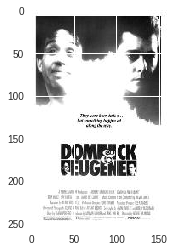

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

Importing the training images

In [14]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg')))

100%|██████████| 7895/7895 [00:05<00:00, 1380.42it/s]


In [15]:
images_training[1000]

array([[253, 252, 255, ..., 253, 255, 246],
       [255, 255, 255, ..., 249, 255, 255],
       [254, 255, 255, ..., 255, 237, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

The next code line allow us to know which are the images dimension for an specific image.

In [16]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 256, 160), 7895)

Then, we will import the testing ones

In [17]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg')))

images_testing = np.stack(images_testing)

100%|██████████| 3383/3383 [00:02<00:00, 1515.34it/s]


In [18]:
images_testing.shape, dataTesting.shape[0]

((3383, 256, 160), 3383)

This will extract the Y variable for our dataset

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

Spliting the dataframe into training and testing

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training, y_genres, test_size=0.2, random_state=42)

In [21]:
y_train_genres.shape

(6316, 24)

now that we have been imported our data (images and text succesfully) we will start to train our models. First we will show the images models and then the text ones, and the end we will compute both results and download the results to upload them through sicua.

## CNN

### Below we will train a CNN using the images in grayout but with just 1 dimension

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from livelossplot import PlotLossesKeras
from keras.optimizers import rmsprop
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.optimizers import adadelta
from keras import optimizers

In [0]:
np.random.seed(4567)
model = Sequential()
N1=256
N2=128
N3=128
kernel = 32

model.add(Conv1D(N1,kernel, input_shape=(256,160)))
model.add(Activation("tanh"))
model.add(Dropout(0.5))

model.add(Conv1D(N2, kernel))
model.add(Activation("tanh"))
#model.add(Dropout(0.5))

model.add(Conv1D(N2, kernel,kernel_initializer='random_uniform'))
model.add(Activation("tanh"))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(N3))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Dense(24))
model.add(Activation("sigmoid"))


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 225, 256)          1310976   
_________________________________________________________________
activation_18 (Activation)   (None, 225, 256)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 225, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 194, 128)          1048704   
_________________________________________________________________
activation_19 (Activation)   (None, 194, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 163, 128)          524416    
_________________________________________________________________
activation_20 (Activation)   (None, 163, 128)          0         
__________

In [0]:
op= optimizers.adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

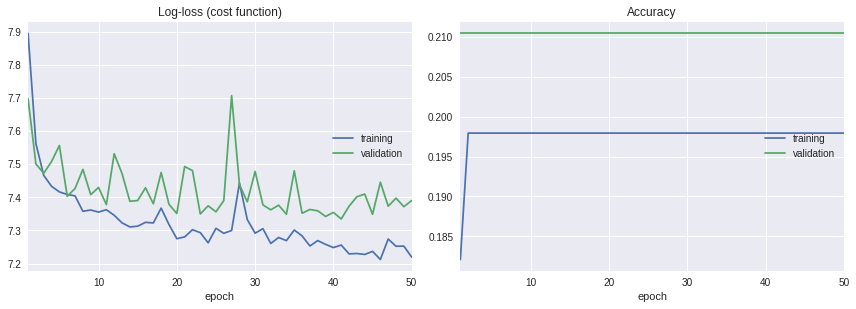

In [0]:
batch_size = 500
model.fit(X_train, y_train_genres, epochs = 50, verbose = 2,batch_size=batch_size, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [0]:
sc=model.evaluate(X_test,y_test_genres)
print(sc[1])

1579/1579 [==============================] - 2s 1ms/step
0.18682710580088957


In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model_CNN = model.predict(X_test)

In [0]:
AUC_CNN = roc_auc_score(y_test_genres, model_CNN, average="macro")
print(AUC_CNN) 

0.5982048624966539


Using a CNN with 3 convolutions and 2 dense layers we got an accuracy of 0.59866

### Know we will use another CNN but first we will transform them

In [22]:
from keras.applications import VGG16
from skimage.transform import resize

vgg16 = VGG16(include_top=False, weights='imagenet')

def apply_vgg_grayscale(images):

    images_ = []
    for img in tqdm(images):

        # reshape
        img = img.reshape((256, 160))

        # rescale
        img = resize(img, (160, 160), mode='reflect')

        # repeat
        img = [img] * 3

        images_.append(img)


    # To numpy array
    images_ = np.array(images_)

    # move channel to last axis
    images_ = np.rollaxis(images_, 1, 4)

    # Apply vgg
    images_vgg = vgg16.predict(images_)
    
    return images_vgg

images_training_vgg = apply_vgg_grayscale(images_training)
images_training_vgg.shape

58892288/58889256 [==============================] - 3s 0us/step


100%|██████████| 7895/7895 [00:23<00:00, 339.11it/s]


(7895, 5, 5, 512)

Transforming also the testing images 

In [23]:
images_testing_vgg = apply_vgg_grayscale(images_testing)
images_testing_vgg.shape

100%|██████████| 3383/3383 [00:09<00:00, 352.49it/s]


(3383, 5, 5, 512)

Creating the split (train and test) to use them as validator before to upload the reults to Kaggle

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_vgg, y_genres, test_size=0.2, random_state=42)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from livelossplot import PlotLossesKeras

In [0]:
np.random.seed(4567)
model_1 = Sequential()
N1=256
N2=128
N3=16
kernel = (3,3)

model_1 = Sequential()
model_1.add(Conv2D(N1, kernel, padding='same', input_shape=(5,5,512)))
model_1.add(Activation('tanh'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.5))

model_1.add(Conv2D(N2, kernel, padding='same'))
model_1.add(Activation('tanh'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
#model_1.add(Dropout(0.5))

model_1.add(Flatten())
model_1.add(Dense(24))
model_1.add(Activation('sigmoid'))

In [27]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 5, 256)         1179904   
_________________________________________________________________
activation_1 (Activation)    (None, 5, 5, 256)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 2, 2, 128)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
__________

In [0]:
op= optimizers.adam(lr=0.0001)
model_1.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

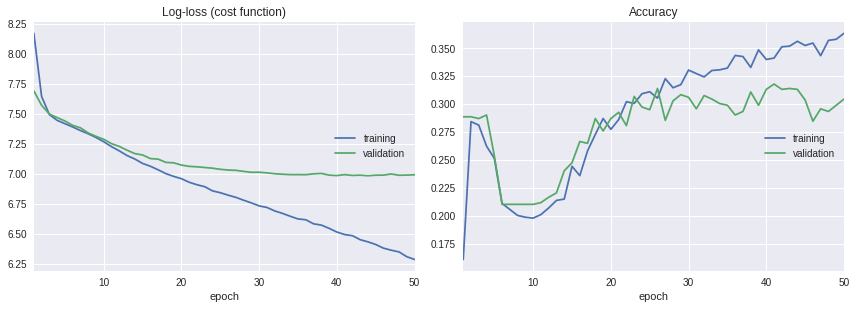

In [0]:
batch_size = 500
model_1.fit(X_train, y_train_genres, epochs = 50, verbose = 2,batch_size=batch_size, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [0]:
sc=model_1.evaluate(X_test,y_test_genres)
print(sc[1])

1579/1579 [==============================] - 0s 211us/step
0.31538948694160274


In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model_pred_1 = model_1.predict(X_test)

In [0]:
auc_model_1 = roc_auc_score(y_test_genres, model_pred_1, average="macro")
print(auc_model_1)

0.7138725056403246


In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_model_1 = model_1.predict_proba(images_testing_vgg)

pd.DataFrame(y_pred_test_model_1, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_Mod_1.csv', index_label='ID')

files.download('pred_genres_img_Mod_1.csv')

# Running a VVG16

We will use the gray images first just for test

In [0]:
np.random.seed(4567)
model_2 = Sequential()
model_2.add(Flatten(input_shape=(5,5,512)))
model_2.add(Dense(512, activation = 'tanh'))
model_2.add(Dropout(0.5))
model_2.add(Dense(24, activation = 'hard_sigmoid'))

In [33]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               6554112   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                12312     
Total params: 6,566,424
Trainable params: 6,566,424
Non-trainable params: 0
_________________________________________________________________


In [0]:
op= optimizers.adam(lr=0.0001)
model_2.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

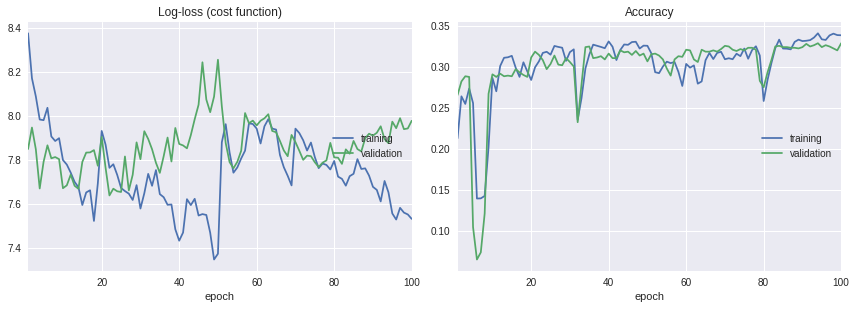

In [35]:
batch_size = 300
model_2.fit(X_train, y_train_genres, epochs = 100, verbose = 2,batch_size=batch_size, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [36]:
sc=model_2.evaluate(X_test,y_test_genres)
print(sc[1])

1579/1579 [==============================] - 0s 162us/step
0.3546548449517504


In [0]:
model_pred_2 = model_2.predict(X_test)

In [38]:
auc_gray = roc_auc_score(y_test_genres, model_pred_2, average="macro")
print(auc_gray)

0.6412190888357324


In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_Mod_2 = model_2.predict_proba(images_testing_vgg)

pd.DataFrame(y_pred_test_Mod_2, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_model_2.csv', index_label='ID')

files.download('pred_genres_img_model_2.csv')

We will use another model including more layers because the previous model was a very small one

In [0]:
np.random.seed(4567)
model_3 = Sequential()
N1=512
N2=256
N3=128
kernel = (3,3)

model_3 = Sequential()
model_3.add(Conv2D(N1, kernel, padding='same', input_shape=(5,5,512)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.5))

model_3.add(Conv2D(N2, kernel, padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
#model_1.add(Dropout(0.5))

model_3.add(Conv2D(N3, kernel, padding='same'))
model_3.add(Activation('relu'))
#model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dropout(0.5))

model_3.add(Flatten())
model_3.add(Dense(24))
model_3.add(Activation('sigmoid'))

In [55]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 5, 5, 512)         2359808   
_________________________________________________________________
activation_16 (Activation)   (None, 5, 5, 512)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 256)         1179904   
_________________________________________________________________
activation_17 (Activation)   (None, 2, 2, 256)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 256)         0         
__________

In [0]:
op= optimizers.adam(lr=0.0001)
model_3.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

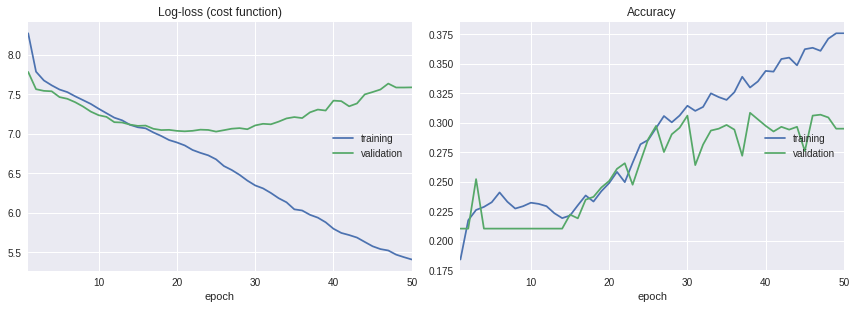

In [57]:
batch_size = 300
model_3.fit(X_train, y_train_genres, epochs = 50, verbose = 2,batch_size=batch_size, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [0]:
model_pred_3 = model_3.predict(X_test)

In [59]:
auc_model_3 = roc_auc_score(y_test_genres, model_pred_3, average="macro")
print(auc_model_3)

0.6972733983807716


In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_Mod_3 = model_3.predict_proba(images_testing_vgg)

pd.DataFrame(y_pred_test_Mod_3, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_mod_3.csv', index_label='ID')

files.download('pred_genres_img_mod_3.csv')

### So our AUC it is between 0.65 and 0.7 using different configurations and the grayout scale 

Know that we have been training our models using VGG16 and got an AUC in Kaggle of 0.778 just uploading images, we will train a diferent TLN model to see what´s happen.



In [0]:
from keras.applications import VGG19
from skimage.transform import resize

model_VGG19 = VGG19(weights='imagenet', include_top=False)

def apply_VGG19_grayscale(images):

    images_ = []
    for img in tqdm(images):

        # reshape
        img = img.reshape((256, 160))

        # rescale
        img = resize(img, (224, 224), mode='reflect')

        # repeat
        img = [img] * 3

        images_.append(img)


    # To numpy array
    images_ = np.array(images_)

    # move channel to last axis
    images_ = np.rollaxis(images_, 1, 4)

    # Apply vgg
    images_vgg19 = model_VGG19.predict(images_)
    
    return images_vgg19

images_training_vgg19 = apply_VGG19_grayscale(images_training)
images_training_vgg19.shape

80142336/80134624 [==============================] - 7s 0us/step


100%|██████████| 7895/7895 [00:28<00:00, 273.48it/s]


In [0]:
images_testing_resnet50 = apply_resnet50_grayscale(images_testing)
images_testing_resnet50.shape

We tried to train the VGG19 and also the ResNet50 but due to the software capacity it wasn´t possible to run thoose models

### Training a new model using a portion of the color images

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '19g4Sphp6RdhvaM3fKXZYe7fxiRtH9Jmu' #1EAoyT_Afx_FkXeDNKUf9yNOC56V9XwXi 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])


In [0]:
! ls

datalab  images_resize_gray  images_resize_gray.zip  Images_resize.zip


In [0]:
!unzip Images_resize.zip> /dev/null

In [0]:
image = io.imread(os.path.join('Images_resize', str(dataTraining.index[50]) + '.jpeg'))


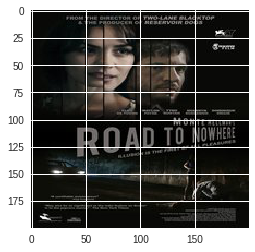

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image)

In [0]:
from keras.preprocessing.image import img_to_array, load_img

images_training = []
for i in tqdm(dataTraining_1.index):
    image_train = load_img(os.path.join('Images_resize', str(i) + '.jpeg'))
    image_train = img_to_array(image_train)
    images_training.append(image_train)
im_tra = np.asarray(images_training)

100%|██████████| 3950/3950 [00:06<00:00, 656.84it/s]


In [0]:
im_tra.shape

(3950, 200, 200, 3)

In [0]:
images_testing = []
for i in tqdm(dataTesting_1.index):
    image_test = load_img(os.path.join('Images_resize', str(i) + '.jpeg'))
    image_test = img_to_array(image_test)
    images_testing.append(image_test)
im_test = np.asarray(images_testing)

100%|██████████| 1700/1700 [00:02<00:00, 633.38it/s]


In [0]:
im_test.shape

(1700, 200, 200, 3)

In [0]:
dataTraining_1['genres'] = dataTraining_1['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres_1 = le.fit_transform(dataTraining_1['genres'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
X_train_1, X_test_1, y_train_genres_1, y_test_genres_1 = train_test_split(im_tra, y_genres_1, test_size=0.2, random_state=42)

In [0]:
from keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
X_test_1.shape

(790, 200, 200, 3)

In [0]:
x_train_pre=model_vgg16.predict(X_train_1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from livelossplot import PlotLossesKeras

In [0]:
x_train_pre.shape

(3160, 6, 6, 512)

In [0]:
np.random.seed(4567)
model_4 = Sequential()
N1=512
N2=256
N3=128
kernel = (3,3)

model_4 = Sequential()
model_4.add(Conv2D(N1, kernel, padding='same', input_shape=(6,6,512)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.5))

model_4.add(Conv2D(N2, kernel, padding='same'))
model_4.add(Activation('tanh'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
#model_1.add(Dropout(0.5))

model_4.add(Conv2D(N3, kernel, padding='same'))
model_4.add(Activation('relu'))
#model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Dense(512, activation = 'relu'))
model_4.add(Dropout(0.5))

model_4.add(Flatten())
model_4.add(Dense(24))
model_4.add(Activation('sigmoid'))

In [0]:
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 6, 6, 512)         2359808   
_________________________________________________________________
activation_5 (Activation)    (None, 6, 6, 512)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 256)         1179904   
_________________________________________________________________
activation_6 (Activation)    (None, 3, 3, 256)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0         
__________

In [0]:
op= optimizers.adam(lr=0.0001)
model_4.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

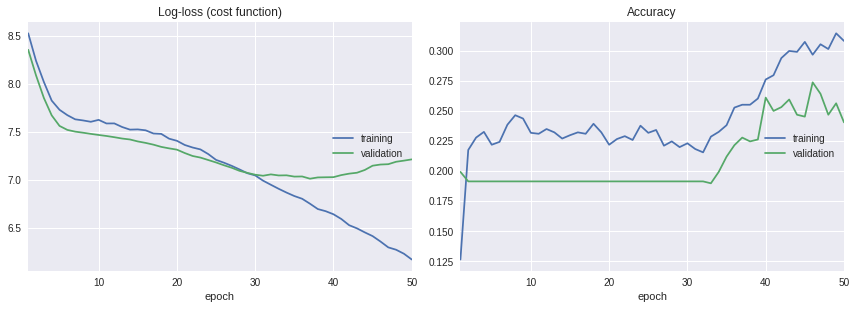

In [0]:
batch_size = 300
model_4.fit(x_train_pre, y_train_genres_1, epochs = 50, verbose = 2,batch_size=batch_size, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [0]:
x_test_pre=model_vgg16.predict(X_test_1)

In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model_pred_4 = model_4.predict(x_test_pre)

In [0]:
auc_model_4 = roc_auc_score(y_test_genres_1, model_pred_4, average="macro")
print(auc_model_4)

NameError: ignored

In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_mod_4 = clf.predict_proba(images_testing)

pd.DataFrame(y_pred_test_mod_4, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_mod_4.csv', index_label='ID')

files.download('pred_genres_img_mod_4.csv')

# Creating a Random Forest

In [0]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:04<00:00, 1605.05it/s]


In [0]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [0]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:02<00:00, 1689.99it/s]


((3383, 40960), 3383)

In [0]:
images_testing.shape

(3383, 40960)

In [0]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_training)

In [0]:
images_testing_pca = pca.transform(images_testing)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training, y_genres, test_size=0.33, random_state=42)

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=8, random_state=42, bootstrap=True, warm_start=True))


In [0]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=True),
          n_jobs=1)

In [0]:
y_pred_RF = clf.predict_proba(X_test)

In [0]:
auc_RF = roc_auc_score(y_test_genres, y_pred_RF, average="macro")
print(auc_RF)

0.5873881352129503


In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_RF = clf.predict_proba(images_testing)

pd.DataFrame(y_pred_test_RF, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

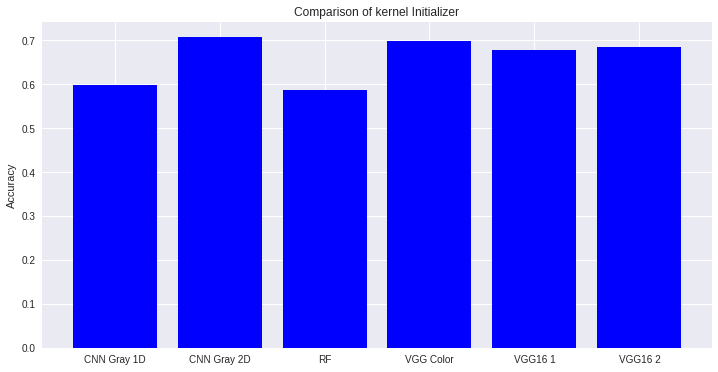

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.bar(["CNN Gray 1D","CNN Gray 2D","VGG16 1","VGG16 2", "VGG Color", "RF"],[0.5974,0.7067,0.678,0.6854,0.6971,0.5873],color="blue",align='center')
plt.title("Comparison of kernel Initializer")
plt.xlabel("",fontsize=12)
plt.ylabel("Accuracy")
plt.show()

So, we got a quite good results using VGG 16 with just half of the images and with a CNN considering the grayout images and 3 layers.

# TEXT MODELS
## MACHINE LEARNING

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

### Read Data

In [0]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","[Drama, Film-Noir, Thriller]",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",[Drama],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","[Action, Crime, Thriller]",6.6


In [0]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Create count vectorizer with ngrams

In [0]:
vect = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [0]:
print(vect.get_feature_names()[:50])

['able', 'able to', 'about', 'about the', 'about to', 'accident', 'across', 'act', 'action', 'actually', 'affair', 'after', 'after the', 'again', 'against', 'against the', 'age', 'agent', 'ago', 'alex', 'alive', 'all', 'all of', 'all the', 'alone', 'along', 'along the', 'along with', 'already', 'also', 'although', 'always', 'america', 'american', 'among', 'an', 'an old', 'and', 'and has', 'and he', 'and her', 'and his', 'and is', 'and she', 'and that', 'and the', 'and their', 'and then', 'and they', 'and when']


### Split train and test

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.2, random_state=42)

In [0]:
type(X_train)

scipy.sparse.csr.csr_matrix

### Train multi-class multi-label model

#### ExtraTreesClassifier

In [0]:
np.random.seed(4567)
clf_etc = OneVsRestClassifier(ExtraTreesClassifier(n_jobs=-1, n_estimators=400, max_depth=6, random_state=42))

In [0]:
clf_etc.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=6, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres_etc = clf_etc.predict_proba(X_test)

In [0]:
acc_etc=roc_auc_score(y_test_genres, y_pred_genres_etc, average='macro')
acc_etc

0.7951939062882706

In [0]:
from google.colab import files

X_test_etc = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres_etc = clf_etc.predict_proba(X_test_etc)

pd.DataFrame(y_pred_test_genres_etc, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_etc.csv', index_label='ID')

files.download('pred_genres_text_RF_etc.csv')

#### AdaBoostClassifier

In [0]:
np.random.seed(4567)
clf_abc = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=42))

In [0]:
clf_abc.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=42),
          n_jobs=1)

In [0]:
y_pred_genres_abc = clf_abc.predict_proba(X_test)

In [0]:
acc_abc=roc_auc_score(y_test_genres, y_pred_genres_abc, average='macro')
acc_abc

0.7659085095059521

In [0]:
X_test_etc = vect.transform(dataTesting['plot'])

In [0]:
y_pred_test_genres_abc = clf_abc.predict_proba(X_test_etc)

#### GradientBoostingClassifier

In [0]:
np.random.seed(4567)
clf_gbc = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=42))

In [0]:
clf_gbc.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres_gbc = clf_gbc.predict_proba(X_test)

In [0]:
acc_gbc=roc_auc_score(y_test_genres, y_pred_genres_gbc, average='macro')
acc_gbc

0.727266555579261

#### Models Comparison

In [0]:
print("ExtraTreesClassifier:      ",acc_etc)
print("AdaBoostClassifier:        ",acc_abc)
print("GradientBoostingClassifier:",acc_gbc)

ExtraTreesClassifier:       0.7951939062882706
AdaBoostClassifier:         0.7659085095059521
GradientBoostingClassifier: 0.727266555579261


### Apply models to kaggle test

In [0]:
X_test_etc = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres_etc = clf_etc.predict_proba(X_test_etc)

pd.DataFrame(y_pred_test_genres_etc, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_etc.csv', index_label='ID')

###############################################################################################################################
X_test_abc = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres_abc = clf_abc.predict_proba(X_test_abc)

pd.DataFrame(y_pred_test_genres_abc, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_abc.csv', index_label='ID')

###############################################################################################################################
X_test_gbc = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres_gbc = clf_gbc.predict_proba(X_test_gbc)

pd.DataFrame(y_pred_test_genres_gbc, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_gbc.csv', index_label='ID')


## LSTM
### Importing libraries required

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [0]:
max_fatures = 1000
tokenizer = Tokenizer(num_words=max_fatures,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
tokenizer.fit_on_texts(dataTraining['plot'].values)
X = tokenizer.texts_to_sequences(dataTraining['plot'].values)
X = pad_sequences(X)
X.shape

(7895, 1228)

In [0]:
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: x.lower())
dataTraining['plot'] = dataTraining['plot'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

dataTesting['plot'] = dataTesting['plot'].apply(lambda x: x.lower())
dataTesting['plot'] = dataTesting['plot'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

### Creating the model

In [0]:
np.random.seed(4567)
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(24,activation='hard_sigmoid'))

In [0]:
from keras.optimizers import rmsprop
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.optimizers import adadelta
from keras.optimizers import Adagrad
from keras import optimizers

op= optimizers.adam(lr=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer=adam(),metrics = ['accuracy'])             # op
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1258, 128)         128000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_20 (Dense)             (None, 24)                4728      
Total params: 387,528
Trainable params: 387,528
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y_genres, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6316, 1258) (6316, 24)
(1579, 1258) (1579, 24)


In [0]:
input_length = X.shape[1]
input_length

1258

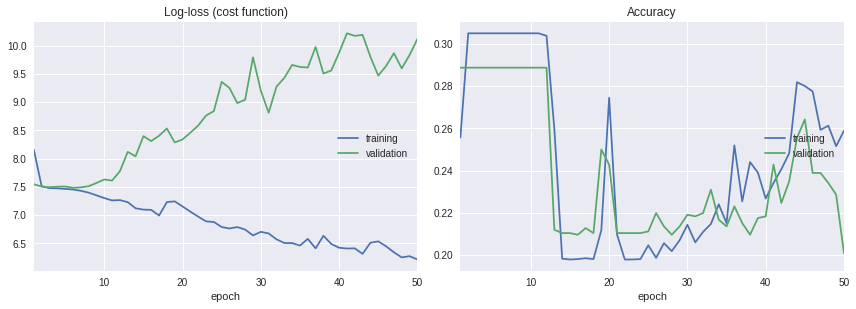

In [0]:
batch_size = 300
model.fit(X_train, Y_train, epochs = 50, verbose = 2,batch_size=batch_size, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [0]:
y_pred = model.predict(X_test)


In [0]:
auc_txt = roc_auc_score(Y_test, y_pred, average="macro")
print(auc_txt)

0.6292353276023533


In [0]:
y_pred[0]

array([0.5125398 , 0.4984861 , 0.49724165, 0.4603435 , 0.55239636,
       0.53142804, 0.47192052, 0.5750453 , 0.5066287 , 0.47960138,
       0.48065332, 0.48227042, 0.49100292, 0.4536614 , 0.4833634 ,
       0.5148015 , 0.46832243, 0.5338018 , 0.49121407, 0.485801  ,
       0.45794925, 0.53349257, 0.4944919 , 0.4783607 ], dtype=float32)

In [0]:
tokenizer2 = Tokenizer(num_words=max_fatures,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
tokenizer2.fit_on_texts(dataTesting['plot'].values)
X2 = tokenizer2.texts_to_sequences(dataTesting['plot'].values)
X2 = pad_sequences(X2)
X2.shape

(3383, 476)

In [0]:
M=np.zeros((3383,1258-476))

In [0]:
X_test_lstm=np.c_[M, X2 ]

In [0]:
X_test_lstm.shape

(3383, 1258)

In [0]:
from google.colab import files

#X_test_lstm = X2

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres_lstm = model.predict_proba(X_test_lstm)

pd.DataFrame(y_pred_test_genres_lstm, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_lstm.csv', index_label='ID')

files.download('pred_genres_text_RF_lstm.csv')

In [0]:
model.save('model1')
model.save('model2')

## Stacking Models

In [0]:
from keras.models import load_model

Model_Images= load_model('model1')
Model_Text= load_model('model2')

In [0]:
predImaValid = Model_Images.predict(xvalidIma)
predTextValid =Model_Text(xvalidTxt)

predImatest = Model_Images.predict(xtextIma)
predTextest =Model_Text(xtextTxt)

In [0]:
import numpy as np

StackTrain =  np.c_[model_pred_1,y_pred_genres_abc]
testkaggle= np.c_[y_pred_test_model_1,y_pred_test_genres_abc]

In [0]:
from google.colab import files

StackModel = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,max_features='sqrt'))
StackModel.fit(StackTrain,y_test_genres)
predKaggle=StackModel.predict_proba(testkaggle)


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']


pd.DataFrame(predKaggle, index=dataTesting.index, columns=cols).to_csv('Stack.csv', index_label='ID')



files.download('Stack.csv')

In [0]:
y_pred_genres_abc.shape, model_pred_1.shape

((1579, 24), (1579, 24))

In [0]:
y_pred_test_genres_abc.shape, y_pred_test_mod_3.shape

((3383, 24), (3383, 24))

In [0]:
y_pred_test_model_1 = model_1.predict_proba(images_testing_vgg)

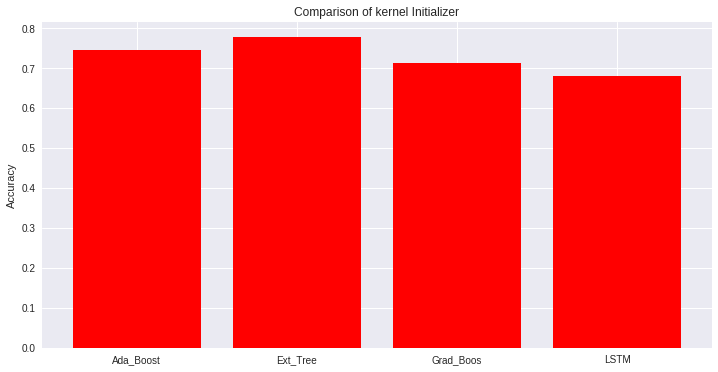

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.bar(["Ext_Tree","Ada_Boost","Grad_Boos","LSTM"],[0.777, 0.746, 0.712, 0.68],color="red",align='center')
plt.title("Comparison of kernel Initializer")
plt.xlabel("",fontsize=12)
plt.ylabel("Accuracy")
plt.show()

In [0]:
ExtraTreesClassifier:       0.7774264463294912
AdaBoostClassifier:         0.7463014472509734
GradientBoostingClassifier: 0.7119974809978756